In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-2.4.4'

In [4]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [5]:
movies = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/movie.csv")\
.persist()

In [22]:
from pyspark.sql.functions import split, regexp_extract
df = movies.select('title', 'genres', 'movieId',regexp_extract('title',r'\((\d+)\)',1).alias('year'))
df.show()

+--------------------+--------------------+-------+----+
|               title|              genres|movieId|year|
+--------------------+--------------------+-------+----+
|    Toy Story (1995)|Adventure|Animati...|      1|1995|
|      Jumanji (1995)|Adventure|Childre...|      2|1995|
|Grumpier Old Men ...|      Comedy|Romance|      3|1995|
|Waiting to Exhale...|Comedy|Drama|Romance|      4|1995|
|Father of the Bri...|              Comedy|      5|1995|
|         Heat (1995)|Action|Crime|Thri...|      6|1995|
|      Sabrina (1995)|      Comedy|Romance|      7|1995|
| Tom and Huck (1995)|  Adventure|Children|      8|1995|
| Sudden Death (1995)|              Action|      9|1995|
|    GoldenEye (1995)|Action|Adventure|...|     10|1995|
|American Presiden...|Comedy|Drama|Romance|     11|1995|
|Dracula: Dead and...|       Comedy|Horror|     12|1995|
|        Balto (1995)|Adventure|Animati...|     13|1995|
|        Nixon (1995)|               Drama|     14|1995|
|Cutthroat Island ...|Action|Ad

In [7]:
movie_trends = df\
.select(explode(split(col("genres"), "\\|")).alias("genres"), col("title"), col("year"), col("movieId"))\
.groupBy(col("year"), col("genres"))\
.agg(count("movieId").alias("movies_count"))\
.orderBy(desc("movies_count"))
movie_trends.show()

+----+------+------------+
|year|genres|movies_count|
+----+------+------------+
|2009| Drama|         507|
|2007| Drama|         475|
|2011| Drama|         471|
|2008| Drama|         465|
|2006| Drama|         446|
|2012| Drama|         439|
|2013| Drama|         437|
|2010| Drama|         429|
|2005| Drama|         402|
|2004| Drama|         365|
|2002| Drama|         362|
|2001| Drama|         337|
|2003| Drama|         336|
|2009|Comedy|         325|
|2000| Drama|         325|
|2014| Drama|         315|
|2012|Comedy|         303|
|2011|Comedy|         287|
|1998| Drama|         284|
|2008|Comedy|         269|
+----+------+------------+
only showing top 20 rows



In [8]:
result = movie_trends.groupBy("year")\
.agg(first(col("genres")).alias("popular_genre"), first(col("movies_count")).alias("total_count"))\
.orderBy(asc("year"))
result.show()

+----+------------------+-----------+
|year|     popular_genre|total_count|
+----+------------------+-----------+
|    |(no genres listed)|          9|
|  06|             Drama|          1|
|1891|(no genres listed)|          1|
|1893|(no genres listed)|          1|
|1894|           Musical|          1|
|1895|       Documentary|          1|
|1896|           Romance|          1|
|1898|(no genres listed)|          3|
|1899|           Fantasy|          1|
|1900|           Romance|          1|
|1901|       Documentary|          1|
|1902|           Fantasy|          1|
|1903|             Crime|          1|
|1905|           Fantasy|          1|
|1909|       Documentary|          1|
|1910|            Sci-Fi|          2|
|1912|             Drama|          3|
|1913|             Drama|          5|
|1914|            Comedy|          6|
|1915|            Comedy|          8|
+----+------------------+-----------+
only showing top 20 rows



In [49]:
movie_trends.coalesce(1).write.csv("hdfs://localhost:9000/MovieData/output/top_genres_each_year.csv")

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121]), <a list of 122 Text xticklabel objects>)

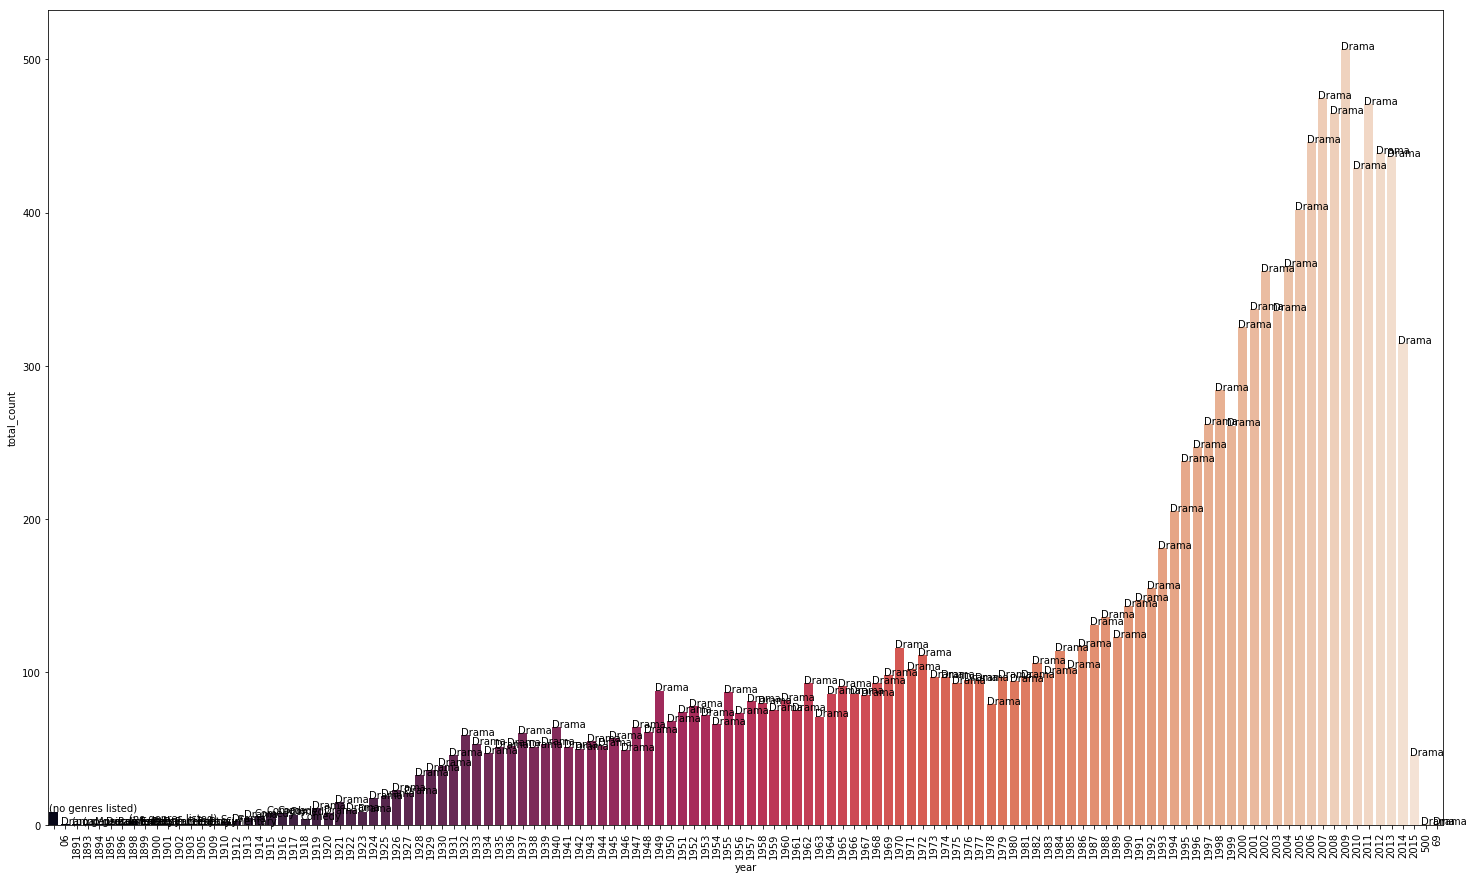

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
%matplotlib inline 

plt.figure(figsize=(25, 15))

#df = new_result.toPandas()
bar_graph = sb.barplot(data = new_result, x = 'year', y = 'total_count', ci = None, palette = 'rocket');

i = 0
for p in bar_graph.patches:
    bar_graph.annotate(new_result.popular_genre[i] , xy=((p.get_x()), (p.get_height()*1)), rotation=0)
    i = i +1
    
plt.xticks(rotation='vertical')

In [17]:
last_result = movie_trends.groupBy("year")\
.agg(last(col("genres")).alias("popular_genre"), last(col("movies_count")).alias("total_count"))\
.orderBy(asc("year"))
last_result.show()

+----+------------------+-----------+
|year|     popular_genre|total_count|
+----+------------------+-----------+
|    |             Crime|          1|
|  06|           Romance|          1|
|1891|(no genres listed)|          1|
|1893|(no genres listed)|          1|
|1894|       Documentary|          1|
|1895|            Comedy|          1|
|1896|       Documentary|          1|
|1898|           Fantasy|          1|
|1899|           Fantasy|          1|
|1900|           Romance|          1|
|1901|       Documentary|          1|
|1902|            Action|          1|
|1903|           Western|          1|
|1905|            Comedy|          1|
|1909|             Crime|          1|
|1910|            Horror|          1|
|1912|         Animation|          1|
|1913|         Adventure|          1|
|1914|           Fantasy|          1|
|1915|            Action|          1|
+----+------------------+-----------+
only showing top 20 rows



(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121]), <a list of 122 Text xticklabel objects>)

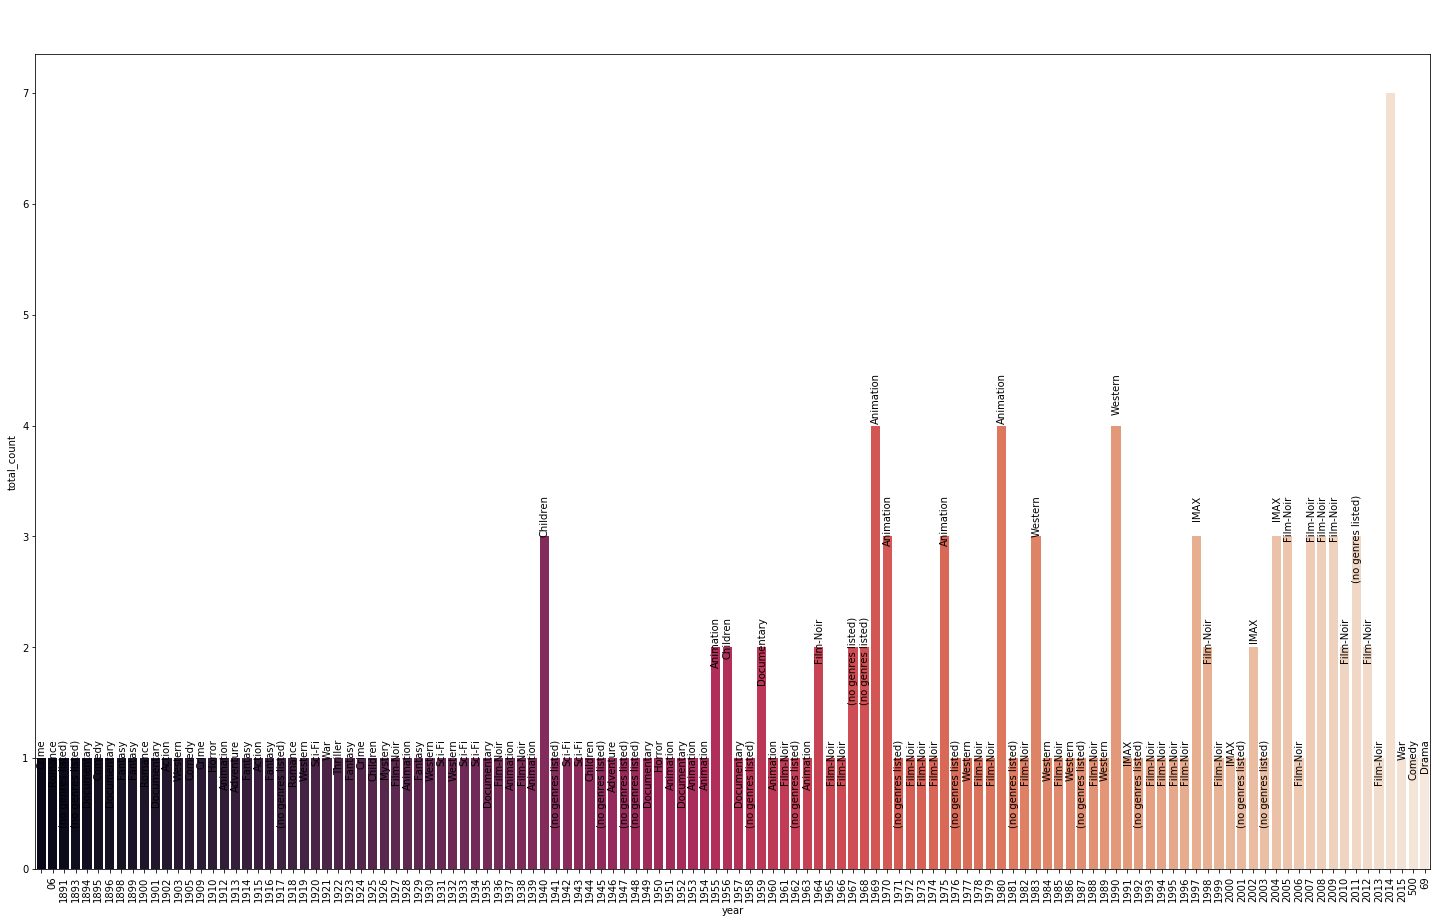

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
%matplotlib inline 

plt.figure(figsize=(25, 15))

#df = new_result.toPandas()
bar_graph = sb.barplot(data = last_result, x = 'year', y = 'total_count', ci = None, palette = 'rocket');

i = 0
for p in bar_graph.patches:
    bar_graph.annotate(last_result.popular_genre[i] , xy=((p.get_x()), (p.get_height()*1.1)), rotation=90)
    i = i +1

plt.xticks(rotation='vertical')